In [1]:
import numpy as np
import json
import pandas as pd
import matplotlib.pyplot as plt
import GPy
from sklearn.linear_model import LinearRegression

In [2]:
num_account = 50000
losses_account_array_single = []
index_array = []
for i in range(num_account):
    f = open("../smallAccount/account_" + str(i) + ".json", "r")
    temp = json.load(f)
    if len(temp['hazard']['perils'][0]["locations"]) == 1:
        losses_account_array_single.append(temp)
        index_array.append(i)
np.random.seed(0)

In [3]:
x_data = []
y_data = []
periods_data = []
year_bulids_array = []
num_floor_array = []
bsum_array = []
for index, losses_account in enumerate(losses_account_array_single):
    x = losses_account["exposure"]["locations"][0]["x"]
    y = losses_account["exposure"]["locations"][0]["y"]
    year = losses_account["exposure"]["locations"][0]["yearBuilt"]
    num_floor = losses_account["exposure"]["locations"][0]["numberFloors"]
    bsum = losses_account["exposure"]["locations"][0]['bsum']
    periods_data_temp = []
    for i in range(len(losses_account['hazard']['perils'][0]["locations"][0]['attributes_rp'][0]["return_periods"])):
        periods_data_temp.append(losses_account['hazard']['perils'][0]["locations"][0]['attributes_rp'][0]["return_periods"][i]['value'])
    periods_data.append(periods_data_temp)
    x_data.append(x)
    y_data.append(y)
    year_bulids_array.append(year)
    num_floor_array.append(num_floor)
    bsum_array.append(bsum)
periods_data = np.array(periods_data, dtype=np.float32)
x_data = np.array(x_data, dtype=np.float32)
y_data = np.array(y_data, dtype=np.float32)
year_bulids_array = np.array(year_bulids_array, dtype=np.float32)
num_floor_array = np.array(num_floor_array, dtype=np.float32)
bsum_array = np.array(bsum_array, dtype=np.float32)

In [4]:
AAL_GU_array = []
EP_GU_array = []
for index in index_array:
    f = open("../results/losses_Account_" + str(index) + ".csv", "r")
    l = f.readlines()
    temp = l[1].split(",")
    AAL_GU_array.append(float(temp[1]))
    EP_GU_array.append(np.array([temp[i+3] for i in range(10)], dtype=np.float32))
AAL_GU_array = np.array(AAL_GU_array, dtype=np.float32)
EP_GU_array = np.array(EP_GU_array, dtype=np.float32)

In [5]:
random_index = np.arange(len(index_array))
np.random.shuffle(random_index)

In [6]:
random_x_data = x_data[random_index]
random_y_data = y_data[random_index]
random_periods_data = periods_data[random_index]
random_AAL_GU_array = AAL_GU_array[random_index]
random_EP_GU_array = EP_GU_array[random_index]
random_bsum_array = bsum_array[random_index]

In [7]:
#1次元のガウス過程回帰
kernel = GPy.kern.RBF(input_dim=9, variance=1., lengthscale=1.)
x = random_periods_data[:, :]
y = np.log(random_AAL_GU_array/random_bsum_array)
x_train = x[:1000]
y_train = y[:1000]
m = GPy.models.GPRegression(x_train, y_train[:, np.newaxis], kernel)
m.optimize(messages=True)

In [13]:
len(x[1000:])

15029

In [15]:
y_test = m.predict(x[1000:])[0]
# relative error
np.linalg.norm(np.exp(y_test).T - random_AAL_GU_array[1000:]/random_bsum_array[1000:])/np.linalg.norm(random_AAL_GU_array[1000:]/random_bsum_array[1000:])*100
# np.linalg.norm(AAL_GU_array[1000:, None]/bsum_array[1000:, None] - np.exp(y_test))/np.linalg.norm(AAL_GU_array[1000:, None]/bsum_array[1000:, None])

0.04105041853970336

In [16]:
0.5/15029

3.326901324106727e-05

Text(0, 0.5, 'latitude')

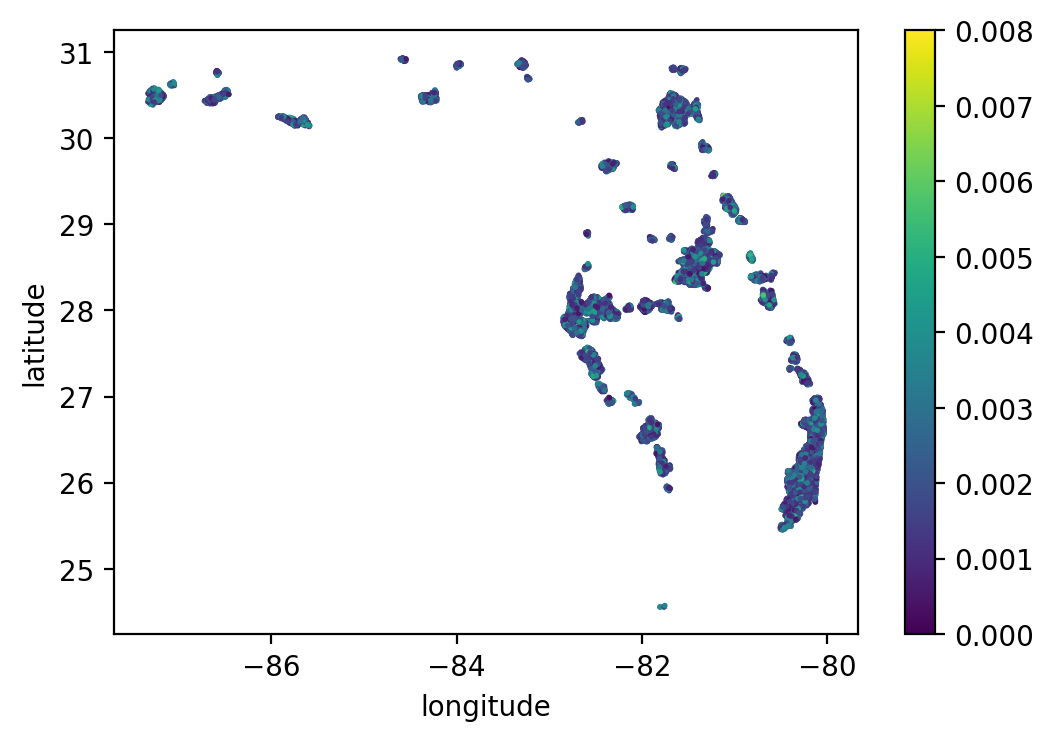

In [41]:
plt.figure(dpi = 200)
plt.scatter(x_data[1000:], y_data[1000:], c=np.exp(y[1000:]), vmin=0, vmax=0.008,s=1)
plt.colorbar()
plt.xlabel("longitude")
plt.ylabel("latitude")

Text(0, 0.5, 'latitude')

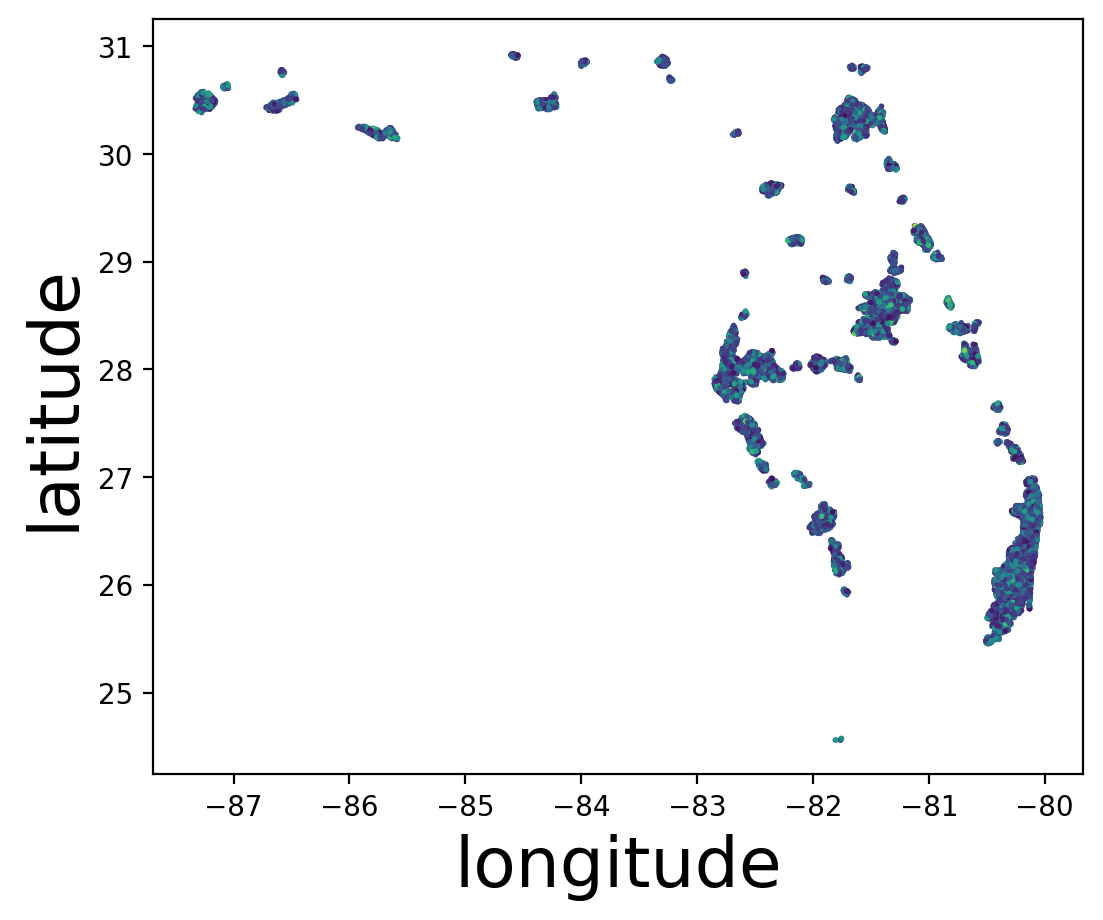

In [61]:
plt.figure(dpi = 200, figsize=(6,5))
plt.scatter(x_data[:], y_data[:], c=np.exp(y[:]),s=1)
# plt.colorbar()
plt.xlabel("longitude", fontsize=25)
plt.ylabel("latitude", fontsize=25)

In [58]:
periods_data[:,0]

array([120.146996, 115.2379  ,  95.90082 , ..., 105.11316 ,  82.72719 ,
       100.40511 ], dtype=float32)

Text(0.5, 1.0, 'Return Period = 10')

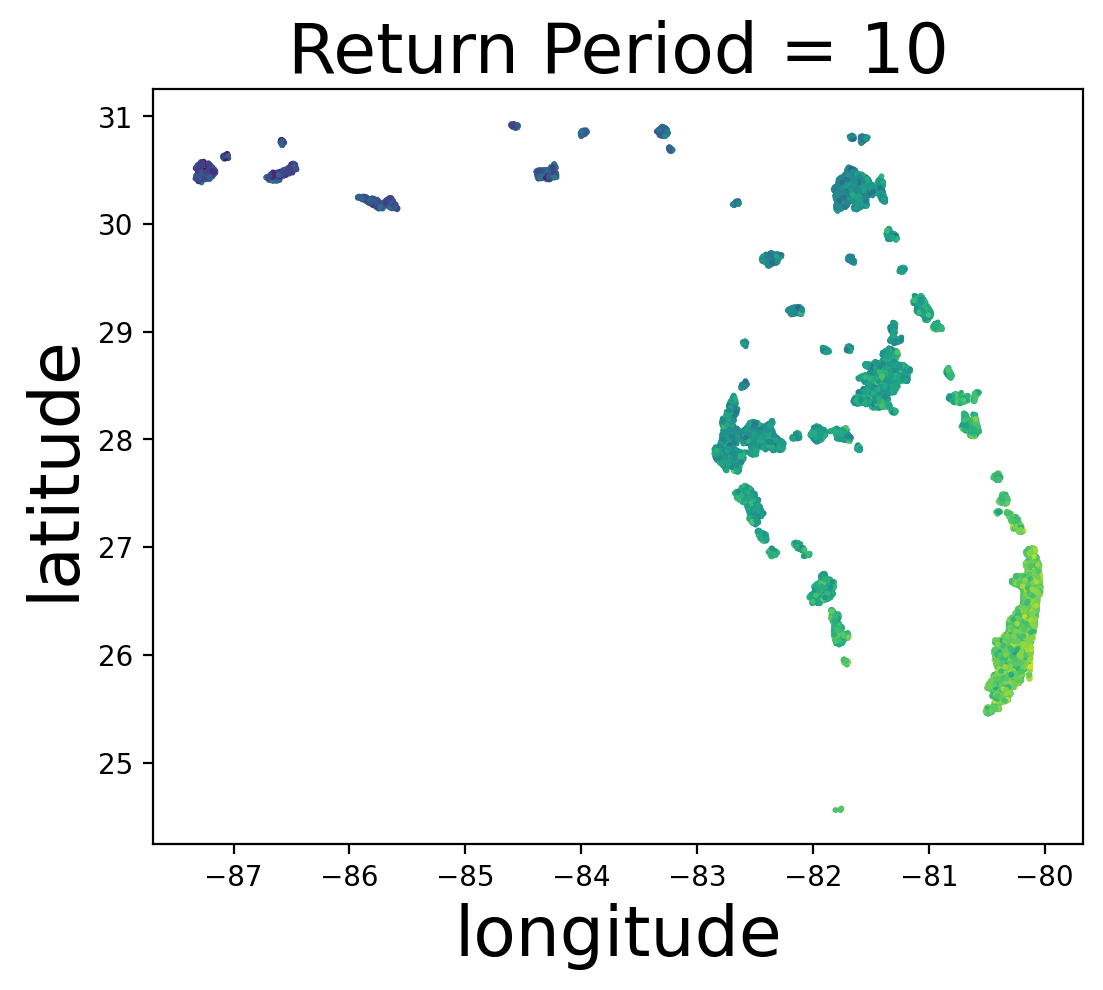

In [63]:
plt.figure(dpi = 200, figsize=(6,5))
plt.scatter(x_data[:], y_data[:], c=periods_data[:,0],s=1)
# plt.colorbar()
plt.xlabel("longitude", fontsize=25)
plt.ylabel("latitude", fontsize=25)
plt.title("Return Period = 10", fontsize=25)

Text(0.5, 1.0, 'Return Period = 2500')

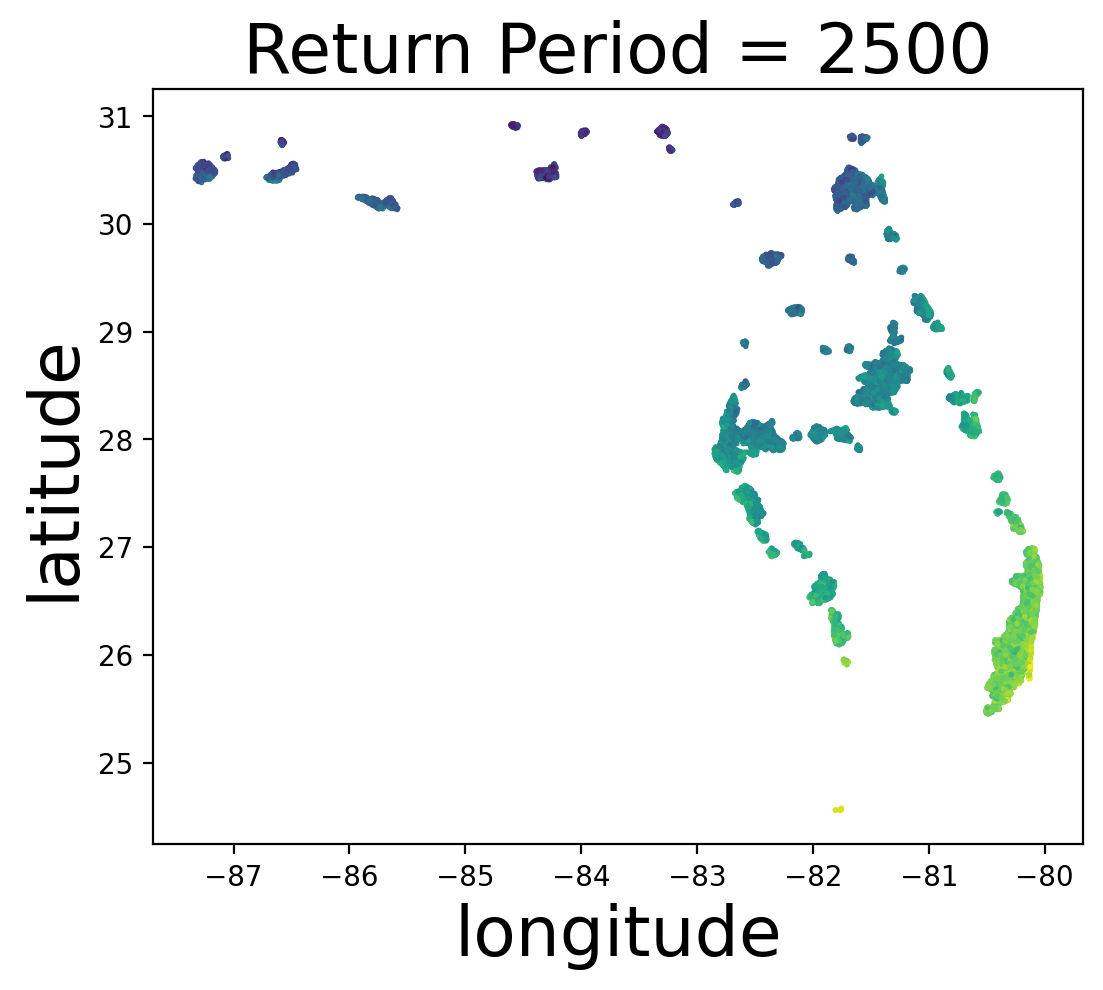

In [65]:
plt.figure(dpi = 200, figsize=(6,5))
plt.scatter(x_data[:], y_data[:], c=periods_data[:,-1],s=1)
# plt.colorbar()
plt.xlabel("longitude", fontsize=25)
plt.ylabel("latitude", fontsize=25)
plt.title("Return Period = 2500", fontsize=25)

Text(0, 0.5, 'latitude')

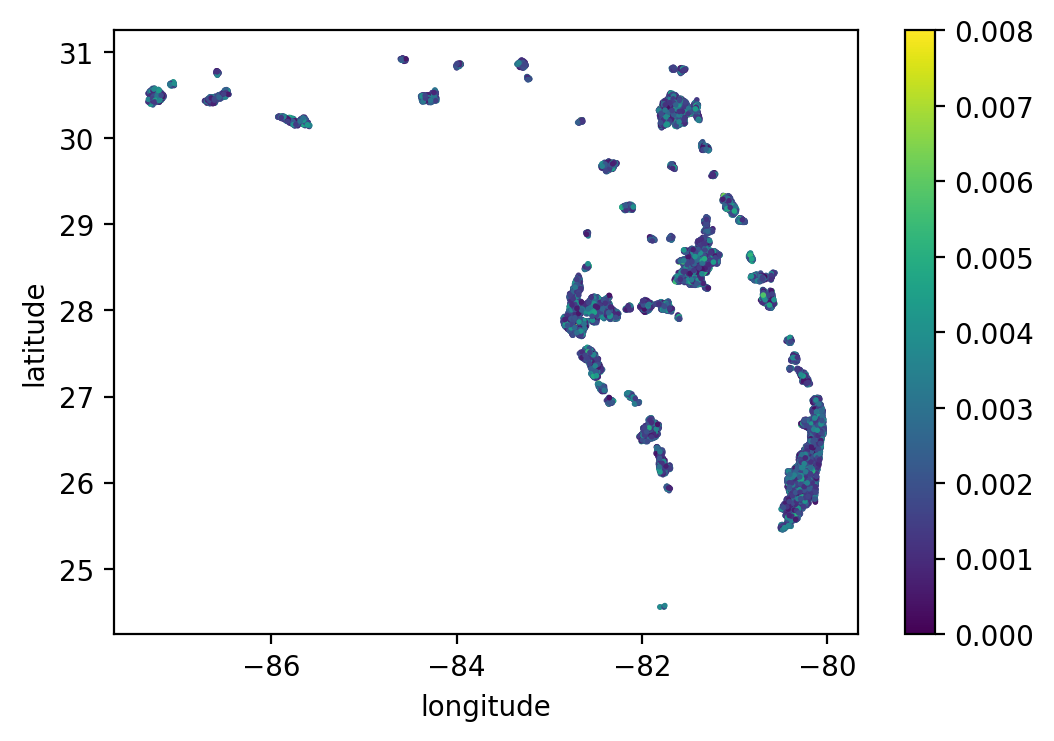

In [42]:
plt.figure(dpi = 200)
plt.scatter(x_data[1000:], y_data[1000:], c=np.exp(y_test), vmin=0, vmax=0.008,s=1)
plt.colorbar()
plt.xlabel("longitude")
plt.ylabel("latitude")

Text(0, 0.5, 'Predicted')

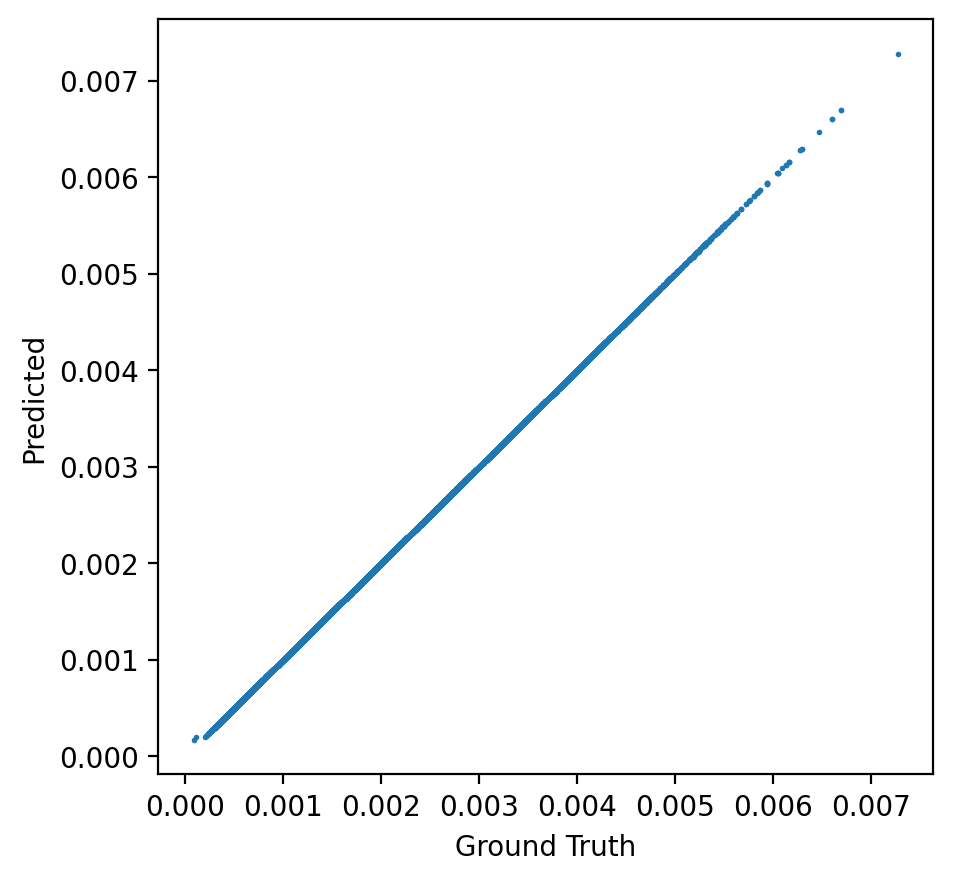

In [47]:
plt.figure(dpi = 200, figsize=(5,5))
plt.scatter(np.exp(y[1000:]),np.exp(y_test), s=1)
plt.xlabel("Ground Truth")
plt.ylabel("Predicted")

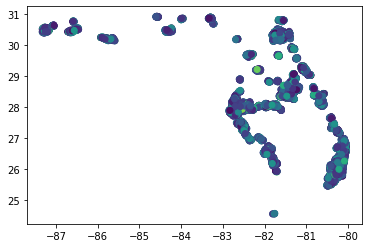

In [61]:
plt.scatter(x_data[2000:], y_data[2000:], c=random_AAL_GU_array[2000:]/random_bsum_array[2000:])

In [49]:
#1次元のガウス過程回帰
kernel = GPy.kern.RBF(input_dim=1, variance=1., lengthscale=1.)
x = random_periods_data[:, 0]
y = np.log(random_AAL_GU_array/random_bsum_array)
x_train = x[:2000]
y_train = y[:2000]
m = GPy.models.GPRegression(x_train[:, None], y_train[:, None], kernel)
m.optimize(messages=True)

TypeError: unsupported format string passed to NoneType.__format__

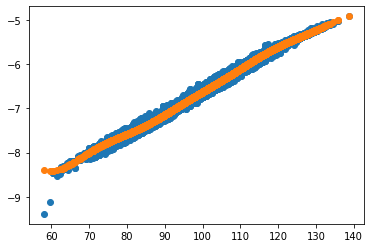

In [18]:
y_test = m.predict(x[2000:, None])[0]
plt.scatter(x[2000:], y[2000:])
plt.scatter(x[2000:], y_test)

In [23]:
np.exp(y_test)

array([[0.00483076],
       [0.00119445],
       [0.00048205],
       ...,
       [0.00101059],
       [0.00139792],
       [0.0022946 ]])

In [22]:
random_AAL_GU_array[2000:]/random_bsum_array[2000:]

array([0.0047924 , 0.00121489, 0.00051555, ..., 0.00094066, 0.00140332,
       0.00214653], dtype=float32)

In [26]:
# relative error
np.linalg.norm(np.exp(y_test).T - random_AAL_GU_array[2000:]/random_bsum_array[2000:])/np.linalg.norm(random_AAL_GU_array[2000:]/random_bsum_array[2000:])
# np.linalg.norm(AAL_GU_array[1000:, None]/bsum_array[1000:, None] - np.exp(y_test))/np.linalg.norm(AAL_GU_array[1000:, None]/bsum_array[1000:, None])

0.04619890462162965

In [28]:
#1次元のガウス過程回帰
model_list = []
for periods in random_periods_data[:,:].T:
    kernel = GPy.kern.RBF(input_dim=1, variance=1., lengthscale=1.)
    x = periods
    y = np.log(random_AAL_GU_array/random_bsum_array)
    x_train = x[:2000]
    y_train = y[:2000]
    m = GPy.models.GPRegression(x_train[:, None], y_train[:, None], kernel)
    m.optimize(messages=True)
    model_list.append(m)

In [29]:
#modelを使って, 1000から5000までのデータを線形回帰
y_test_list = []
for i, model in enumerate(model_list):
    y_test_list.append(model.predict(periods_data[2000:, i][:, None])[0])
model = LinearRegression()
X = np.column_stack([y_test_list[i] for i in range(9)])
y = np.log(AAL_GU_array[2000:, None]/bsum_array[2000:, None])
# 線形回帰モデルの作成
model = LinearRegression()
model.fit(X[:4000], y[:4000])

# 結果の出力
print("回帰係数:", model.coef_)     # 各ベクトル列(y1, y2, y3)に対する係数
print("切片:", model.intercept_)    # 切片（y軸との交点）

# モデルによる予測
y_pred = model.predict(X[4000:])
print("予測値:", y_pred)

回帰係数: [[  0.20725942   0.47808706   0.44026733  -2.70339574   4.69183128
  -30.88100174  29.69878284  -0.99190143   0.06287106]]
切片: [0.01764522]
予測値: [[-6.46414716]
 [-6.11673496]
 [-5.48972907]
 ...
 [-6.50769616]
 [-7.30036123]
 [-6.63033856]]


In [30]:
#relative error
np.linalg.norm(np.exp(y_pred) - AAL_GU_array[6000:, None]/bsum_array[6000:, None])/np.linalg.norm(AAL_GU_array[6000:, None]/bsum_array[6000:, None])

0.004843974318637261

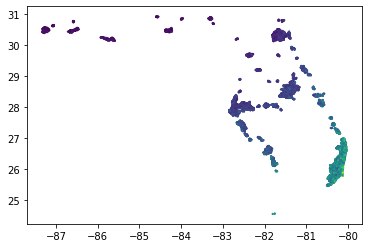

In [34]:
plt.scatter(x_data[6000:], y_data[6000:], c = np.array(np.exp(y_pred), dtype=np.float32), s = 1)

In [45]:
np.max(np.exp(y_pred)-AAL_GU_array[6000:, None]/bsum_array[6000:, None])

0.00013256190662742917

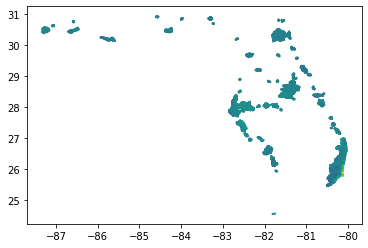

In [46]:
plt.scatter(x_data[6000:], y_data[6000:], c = np.array(np.exp(y_pred)-AAL_GU_array[6000:, None]/bsum_array[6000:, None], dtype=np.float32), s = 1)

(array([1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 2.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 2.000e+00, 0.000e+00,
        2.000e+00, 1.000e+00, 2.000e+00, 1.400e+01, 1.400e+01, 1.300e+01,
        2.400e+01, 3.900e+01, 3.100e+01, 5.500e+01, 3.000e+01, 8.500e+01,
        1.090e+02, 1.230e+02, 1.670e+02, 2.440e+02, 3.410e+02, 4.740e+02,
        5.930e+02, 8.010e+02, 1.182e+03, 1.298e+03, 9.930e+02, 9.080e+02,
        8.530e+02, 6.050e+02, 4.040e+02, 2.220e+02, 1.080e+02, 7.000e+01,
        4.600e+01, 2.100e+01, 2.200e+01, 1.600e+01, 9.000e+00, 8.000e+00,
        7.000e+00, 7.000e+00, 8.000e+00, 8.000e+00, 1.000e+00, 1.000e+01,
        1.100e+01, 4.000e+00, 1.000e+00, 4.000e+00, 5.000e+00, 1.000e+00,
        1.000e+00, 3.000e+00, 7.000e+00, 5.000e+00, 1.000e+00, 1.000e+00,
        1.000e+00, 1.000e+00, 2.000e+0

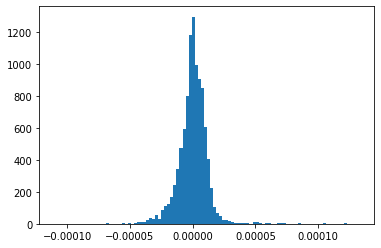

In [47]:
plt.hist(np.exp(y_pred)-AAL_GU_array[6000:, None]/bsum_array[6000:, None], bins=100)